In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, Tuple, Optional, List
import json
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import sys

sys.path.append('..')
from src.train_transfer_learning import *
warnings.filterwarnings('ignore')

In [18]:
from importlib import reload
from src import cv_transfer_util

reload(cv_transfer_util)

<module 'src.cv_transfer_util' from '/home/georgios/PGMP/notebooks/../src/cv_transfer_util.py'>

In [12]:
# Load labels
labels_df = pd.read_parquet('../data/processed/core_dataset.parquet')
labels_df = labels_df.set_index('song_id')
labels_df.index = labels_df.index.astype(int)
    
print(f"Loaded {len(labels_df)} songs")
print(f"Valence: {labels_df['valence_mean'].mean():.3f} ± {labels_df['valence_mean'].std():.3f}")
print(f"Arousal: {labels_df['arousal_mean'].mean():.3f} ± {labels_df['arousal_mean'].std():.3f}")

Loaded 1802 songs
Valence: 4.904 ± 1.174
Arousal: 4.814 ± 1.282


In [13]:
from src.make_dataset.split_data import load_splits_triplet
train_ids, val_ids, test_ids = load_splits_triplet()

In [14]:
models = ['panns', 'ast', 'musicnn', 'vggish', 'clap']
names = {'panns': 'PANNs', 'ast': 'AST', 'musicnn': 'Musicnn', 'vggish': 'VGGish', 'clap': 'CLAP'}
backbone_name = {'panns': 'effb0', 'ast': 'mobv3', 'musicnn': 'mobv3', 'vggish': 'effb0', 'clap': 'effb0'}
freeze_backbone = True

keeping whole backbone frozen here (limited data), only the adapter and the regressor head learn.

In [15]:
from src.cv_transfer_util import train_deam_only, set_seed
set_seed(42)
for m_type in models:
    model, history, test_metrics = train_deam_only(
        model_type=m_type,
        backbone=None, # will pick automatically best defaults
        deam_spec_dir=Path(f"../data/processed/mel_spectrograms_{m_type}"),
        deam_labels=labels_df, # index: song_id
        train_ids=train_ids, val_ids=val_ids, test_ids=test_ids,
        freeze_backbone=freeze_backbone,
        lr=1e-4, epochs=50, patience=8,
        ckpt_path=Path(f"../results/transfer/{names[m_type]}_{backbone_name[m_type]}/best.ckpt")
    )

DEAM-only | model_type=panns | backbone=efficientnet_b0 | freeze_backbone=True
Dataset: 5028 segments from 1257 songs [deam]
Dataset: 1104 segments from 276 songs [deam]
Dataset: 1076 segments from 269 songs [deam]
Best epoch 10 | val_loss=0.0557 | RMSE V/A=0.876/0.890 | R2 V/A=0.444/0.550
TEST RMSE(V/A) 0.942/0.947 | R2(V/A) 0.353/0.474
DEAM-only | model_type=vggish | backbone=efficientnet_b0 | freeze_backbone=True
Dataset: 5028 segments from 1257 songs [deam]
Dataset: 1104 segments from 276 songs [deam]
Dataset: 1076 segments from 269 songs [deam]
Best epoch 10 | val_loss=0.0618 | RMSE V/A=0.912/0.970 | R2 V/A=0.398/0.466
TEST RMSE(V/A) 1.000/0.992 | R2(V/A) 0.271/0.422
DEAM-only | model_type=clap | backbone=efficientnet_b0 | freeze_backbone=True
Dataset: 5028 segments from 1257 songs [deam]
Dataset: 1104 segments from 276 songs [deam]
Dataset: 1076 segments from 269 songs [deam]
Best epoch 10 | val_loss=0.0528 | RMSE V/A=0.850/0.877 | R2 V/A=0.477/0.564
TEST RMSE(V/A) 0.904/0.948 | 

### Pretrain on Deezer -> Fine-tune on DEAM

here testing unfreezing last 1 and 2 blocks of the backbone to squeeze out more domain adaptation (keeping batchnorm frozen still), since more data are available with pretraining(~12000 total unique song samples)

In [16]:
# Load deezer csvs
deezer_train = pd.read_parquet('../data/Deezer/train.parquet')
deezer_val   = pd.read_parquet('../data/Deezer/val.parquet')
deezer_test  = pd.read_parquet('../data/Deezer/test.parquet')

# pretraining doesn't need testing, add the test set into the training set for bigger data input
deezer_train_full = pd.concat([deezer_train, deezer_test], ignore_index=True)
deezer_val = deezer_val.reset_index(drop=True)

deezer_df = pd.concat([deezer_train_full, deezer_val], ignore_index=True)
deezer_df['dzr_sng_id'] = deezer_df['dzr_sng_id'].astype(int)
deezer_df = deezer_df.drop_duplicates('dzr_sng_id', keep='last')[['dzr_sng_id','valence','arousal']]

deezer_train_ids = deezer_train_full['dzr_sng_id'].astype(int).tolist()
deezer_val_ids   = deezer_val['dzr_sng_id'].astype(int).tolist()
assert set(deezer_val_ids).isdisjoint(set(deezer_train_ids)), "Deezer val leaked into train"

In [19]:
from src.cv_transfer_util import deezer_pretrain_then_deam_finetune, set_seed

for m_type in models:
    model, history, test_metrics = deezer_pretrain_then_deam_finetune(
        model_type=m_type,
        backbone=None,
        deezer_spec_dir=Path(f"../data/processed/DEEZER/mel_spectrograms_{m_type}"),
        deezer_df=deezer_df,
        deezer_train_ids=deezer_train_ids,
        deezer_val_ids=deezer_val_ids,
        deam_spec_dir=Path(f"../data/processed/mel_spectrograms_{m_type}"),
        deam_labels=labels_df,
        deam_train_ids=train_ids, deam_val_ids=val_ids, deam_test_ids=test_ids,
        freeze_backbone_finetune=True,
        pre_epochs=15, pre_lr=1e-4,
        ft_epochs=30,  ft_lr=1e-5,
        pre_ckpt=Path(f"../results/transfer/{names[m_type]}_{backbone_name[m_type]}/pretrained_2_blocks.ckpt"),
        ft_ckpt=Path(f"../results/transfer/{names[m_type]}_{backbone_name[m_type]}/finetuned_2_blocks.ckpt")
    )

Pretrain(FULL) on Deezer → Finetune on DEAM | model_type=panns | backbone=efficientnet_b0
Dataset: 28097 segments from 9352 songs [deezer]
Dataset: 7457 segments from 2482 songs [deezer]
Best epoch 4 | val_loss=0.0952 | RMSE V/A=0.980/0.832 | R2 V/A=0.142/0.226
Dataset: 5028 segments from 1257 songs [deam]
Dataset: 1104 segments from 276 songs [deam]
Dataset: 1076 segments from 269 songs [deam]
Loaded head-only weights from ../results/transfer/PANNs_effb0/pretrained_2_blocks.ckpt
Best epoch 12 | val_loss=0.0531 | RMSE V/A=0.847/0.905 | R2 V/A=0.480/0.535
TEST RMSE(V/A) 0.896/0.970 | R2(V/A) 0.414/0.448
Pretrain(FULL) on Deezer → Finetune on DEAM | model_type=ast | backbone=mobilenet_v3_small
Dataset: 28097 segments from 9352 songs [deezer]
Dataset: 7457 segments from 2482 songs [deezer]
Best epoch 9 | val_loss=0.0923 | RMSE V/A=0.970/0.816 | R2 V/A=0.161/0.256
Dataset: 5028 segments from 1257 songs [deam]
Dataset: 1104 segments from 276 songs [deam]
Dataset: 1076 segments from 269 song

### Plot training histories

In [20]:
from src.viz_dl import *

saved: ../results/plots/transfer_learning/cv/deam_only/valence_rmse_training.png


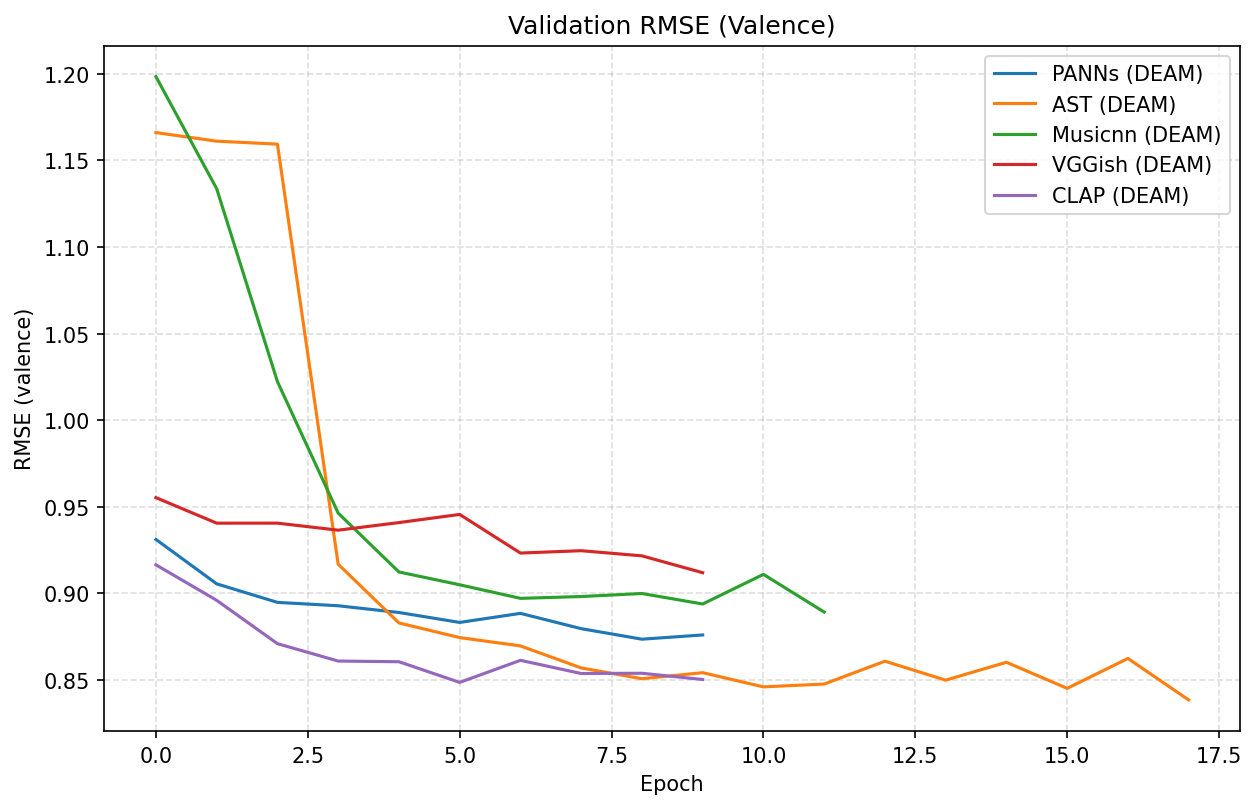

In [21]:
ckpts = {
    "PANNs (DEAM)":       "../results/transfer/PANNs_effb0/best.ckpt",
    "AST (DEAM)":         "../results/transfer/AST_mobv3/best.ckpt",
    "Musicnn (DEAM)":     "../results/transfer/Musicnn_mobv3/best.ckpt",
    "VGGish (DEAM)":      "../results/transfer/VGGish_effb0/best.ckpt",
    "CLAP (DEAM)":        "../results/transfer/CLAP_effb0/best.ckpt",
    
}
histories = load_histories_from_ckpts(ckpts)
plot_histories_val_rmse(histories, savename=Path("../results/plots/transfer_learning/cv/deam_only/valence_rmse_training.png"))

In [22]:
ckpts_with_pretraining_1 = {
    "PANNs (+Deezer)":    "../results/transfer/PANNs_effb0/finetuned_1_block.ckpt",
    "AST (+Deezer)":      "../results/transfer/AST_mobv3/finetuned_1_block.ckpt",
    "Musicnn (+Deezer)":  "../results/transfer/Musicnn_mobv3/finetuned_1_block.ckpt",
    "VGGish (+Deezer)":   "../results/transfer/VGGish_effb0/finetuned_1_block.ckpt",
    "CLAP (+Deezer)":     "../results/transfer/CLAP_effb0/finetuned_1_block.ckpt",
}

saved: ../results/plots/transfer_learning/cv/with_pretraining_1/valence_rmse_training.png


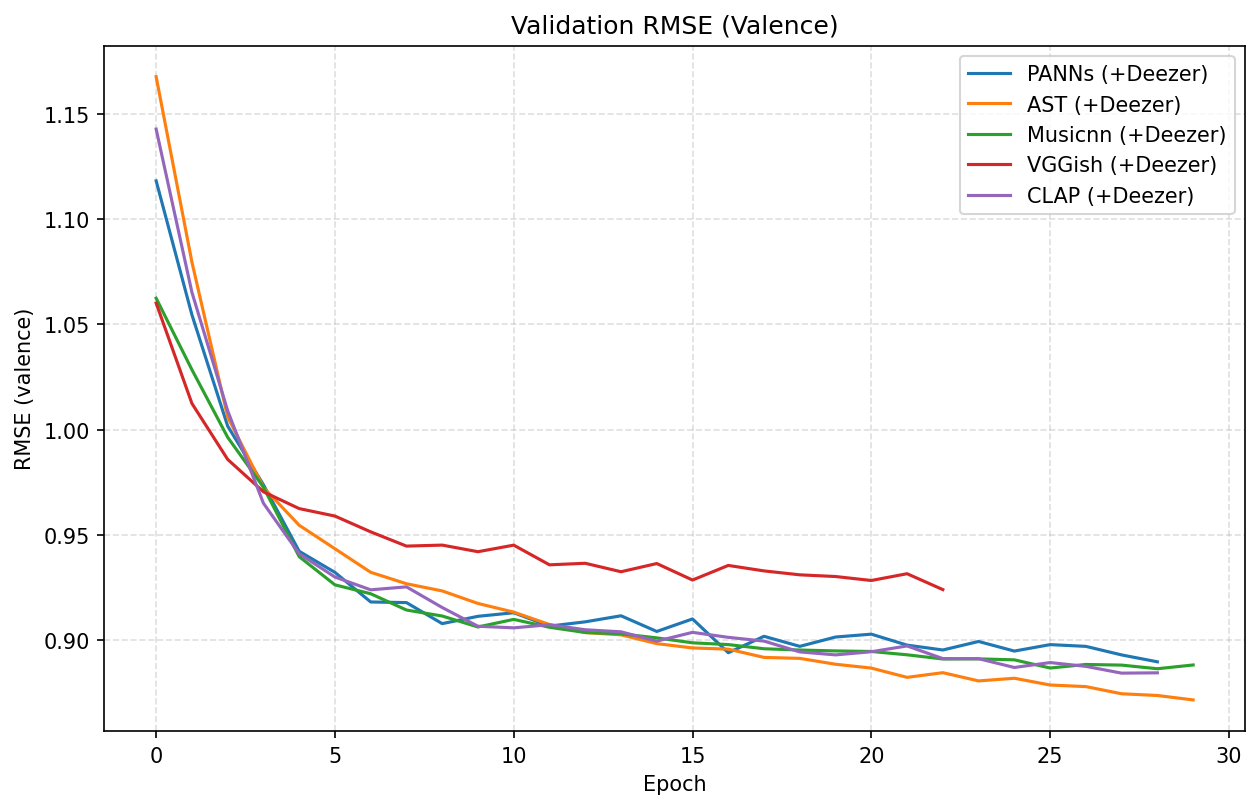

In [23]:
histories_with_pretraining_1 = load_histories_from_ckpts(ckpts_with_pretraining_1)
plot_histories_val_rmse(histories_with_pretraining_1,
                        savename=Path("../results/plots/transfer_learning/cv/with_pretraining_1/valence_rmse_training.png"))

In [24]:
ckpts_with_pretraining_2 = {
    "PANNs (+Deezer)":    "../results/transfer/PANNs_effb0/finetuned_2_blocks.ckpt",
    "AST (+Deezer)":      "../results/transfer/AST_mobv3/finetuned_2_blocks.ckpt",
    "Musicnn (+Deezer)":  "../results/transfer/Musicnn_mobv3/finetuned_2_blocks.ckpt",
    "VGGish (+Deezer)":   "../results/transfer/VGGish_effb0/finetuned_2_blocks.ckpt",
    "CLAP (+Deezer)":     "../results/transfer/CLAP_effb0/finetuned_2_blocks.ckpt",
}

saved: ../results/plots/transfer_learning/cv/with_pretraining_2/valence_rmse_training.png


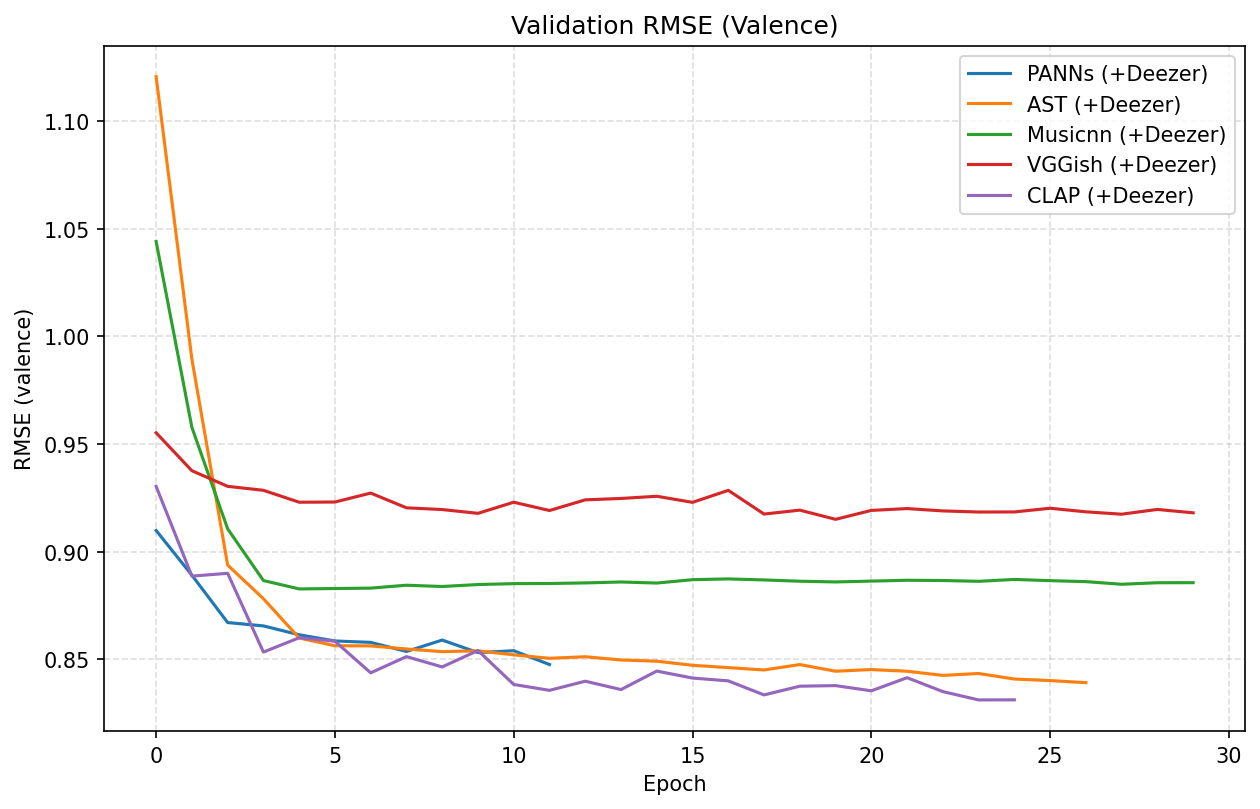

In [25]:
histories_with_pretraining_2 = load_histories_from_ckpts(ckpts_with_pretraining_2)
plot_histories_val_rmse(histories_with_pretraining_2,
                        savename=Path("../results/plots/transfer_learning/cv/with_pretraining_2/valence_rmse_training.png"))

### test metrics barplots

saved: ../results/plots/transfer_learning/test_metrics_bar_deam_only.png


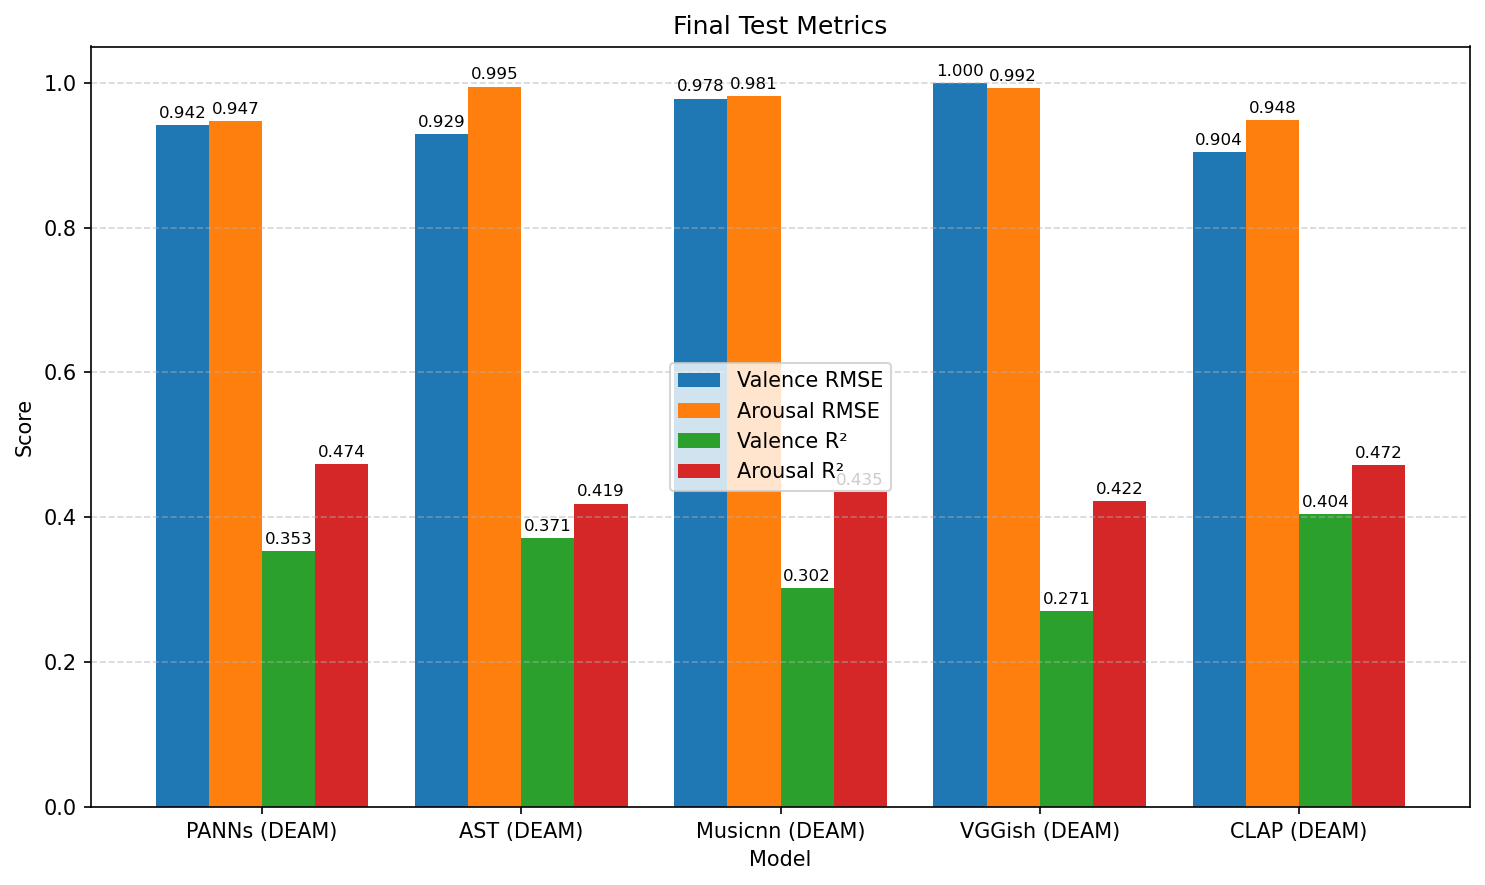

In [36]:
jsons = {
    "PANNs (DEAM)":      "../results/transfer/PANNs_effb0/test_metrics.json",
    "AST (DEAM)":        "../results/transfer/AST_mobv3/test_metrics.json",
    "Musicnn (DEAM)":    "../results/transfer/Musicnn_mobv3/test_metrics.json",
    "VGGish (DEAM)":     "../results/transfer/VGGish_effb0/test_metrics.json",
    "CLAP (DEAM)":       "../results/transfer/CLAP_effb0/test_metrics.json",
}
results = load_results_from_jsons(jsons)

# Bar chart with all four metrics
plot_results_bar(results, savename=Path("../results/plots/transfer_learning/test_metrics_bar_deam_only.png"))

saved: ../results/plots/transfer_learning/test_metrics_bar_valence_rmse.png


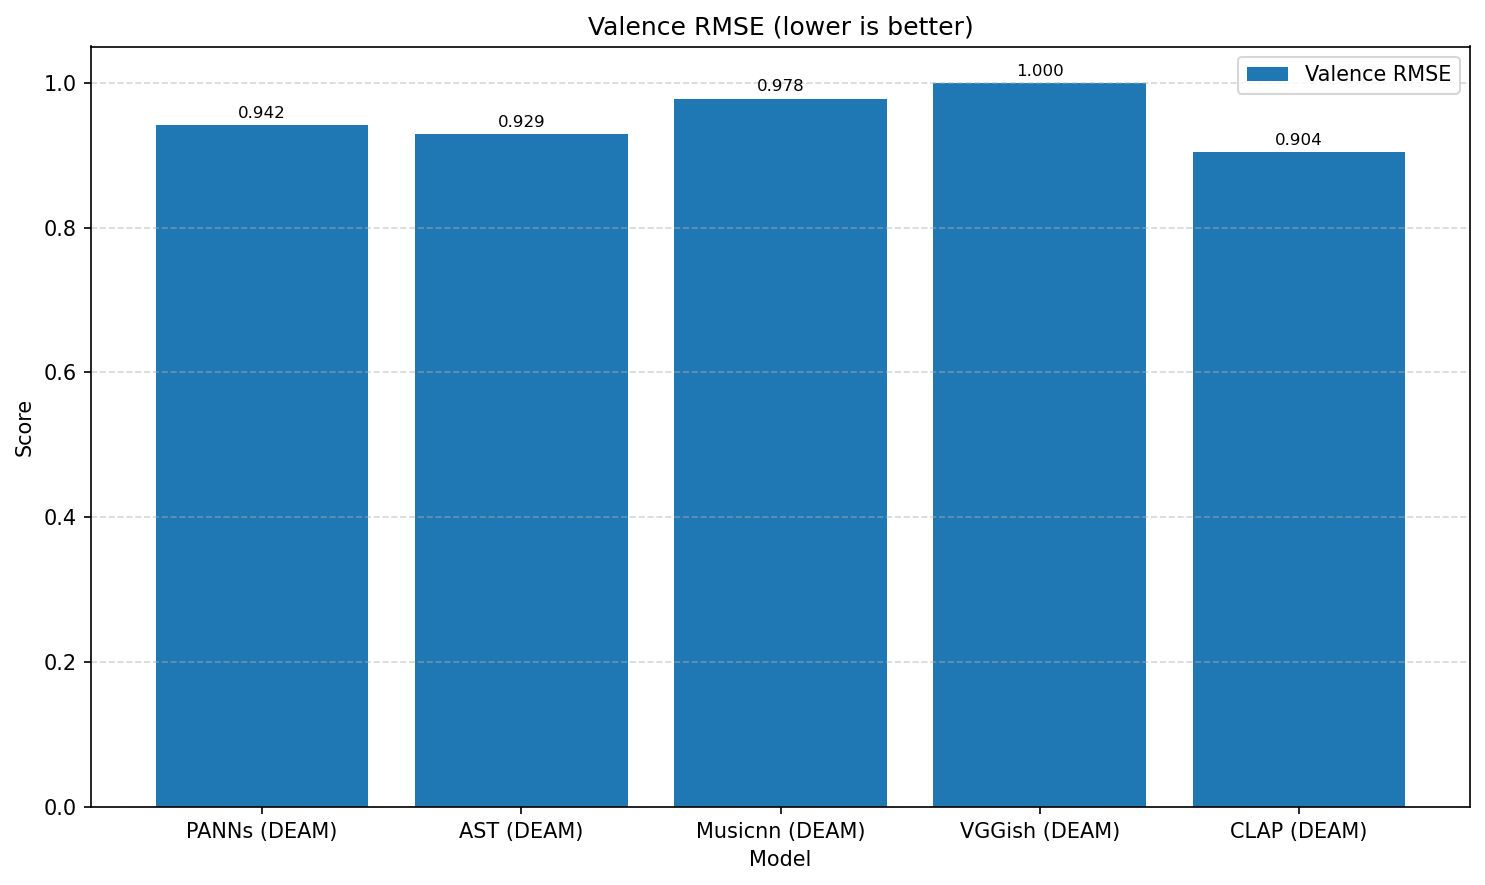

In [37]:
# Just valence RMSE
plot_results_bar(results, metric_keys=("Valence RMSE",),
                 savename=Path("../results/plots/transfer_learning/test_metrics_bar_valence_rmse.png"),
                 title="Valence RMSE (lower is better)")

In [38]:
jsons_with_pretraining_1 = {
    "PANNs (+Deezer)":   "../results/transfer/PANNs_effb0/test_metrics_1_block_with_pretraining.json",
    "AST (+Deezer)":     "../results/transfer/AST_mobv3/test_metrics_1_block_with_pretraining.json",
    "Musicnn (+Deezer)": "../results/transfer/Musicnn_mobv3/test_metrics_1_block_with_pretraining.json",
    "VGGish (+Deezer)":  "../results/transfer/VGGish_effb0/test_metrics_1_block_with_pretraining.json",
    "CLAP (+Deezer)":    "../results/transfer/CLAP_effb0/test_metrics_1_block_with_pretraining.json",
}

saved: ../results/plots/transfer_learning/test_metrics_bar_with_pretraining_1_block_unfrozen.png


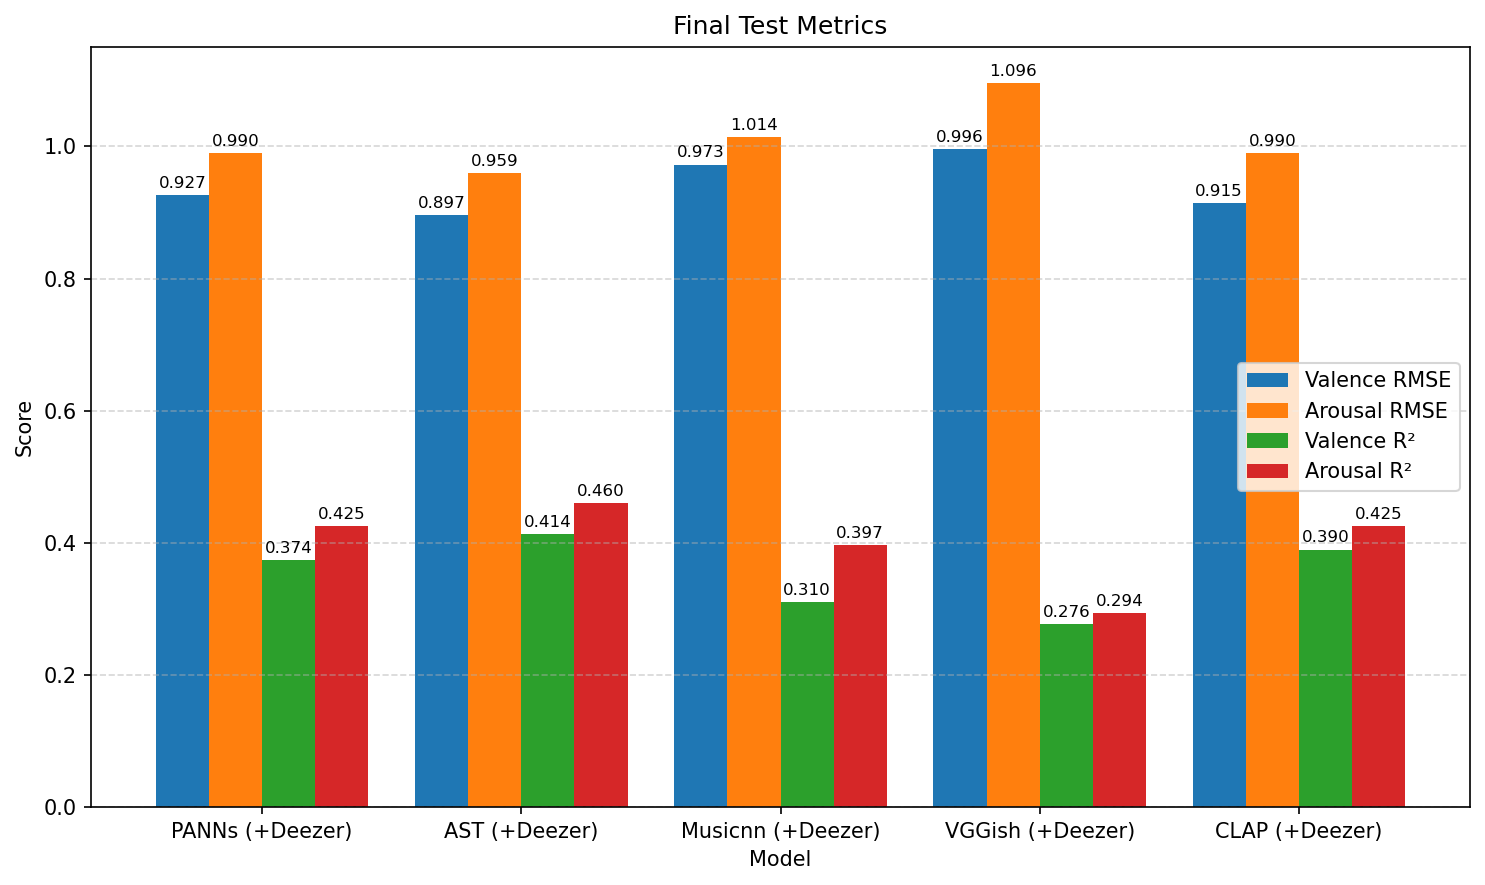

In [39]:
results_1 = load_results_from_jsons(jsons_with_pretraining_1)
# Bar chart with all four metrics
plot_results_bar(results_1, savename=Path("../results/plots/transfer_learning/test_metrics_bar_with_pretraining_1_block_unfrozen.png"))

In [43]:
jsons_with_pretraining_2 = {
    "PANNs (+Deezer)":   "../results/transfer/PANNs_effb0/test_metrics_2_blocks_with_pretraining.json",
    "AST (+Deezer)":     "../results/transfer/AST_mobv3/test_metrics_2_blocks_with_pretraining.json",
    "Musicnn (+Deezer)": "../results/transfer/Musicnn_mobv3/test_metrics_2_blocks_with_pretraining.json",
    "VGGish (+Deezer)":  "../results/transfer/VGGish_effb0/test_metrics_2_blocks_with_pretraining.json",
    "CLAP (+Deezer)":    "../results/transfer/CLAP_effb0/test_metrics_2_blocks_with_pretraining.json",
}

saved: ../results/plots/transfer_learning/test_metrics_bar_with_pretraining_2_blocks_unfrozen.png


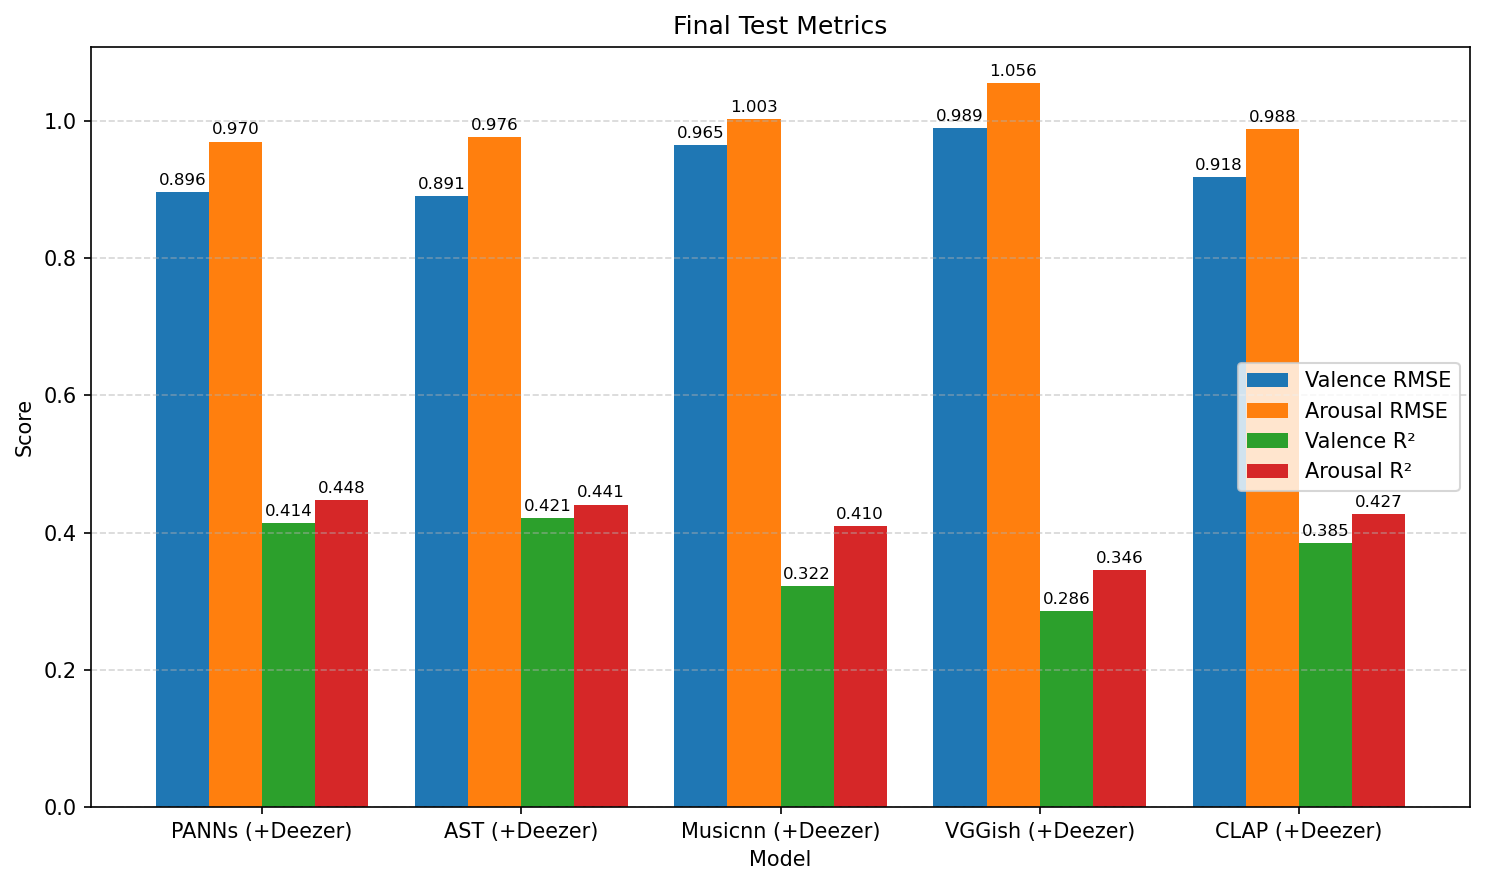

In [44]:
results_2 = load_results_from_jsons(jsons_with_pretraining_2)
# Bar chart with all four metrics
plot_results_bar(results_2, savename=Path("../results/plots/transfer_learning/test_metrics_bar_with_pretraining_2_blocks_unfrozen.png"))

### Testing the original split for comparison

In [46]:
train_ids, val_ids, test_ids = load_splits_triplet(name='original') # load the original DEAM splits (58 full song test set)

In [48]:
len(test_ids)

58

In [49]:
from src.cv_transfer_util import train_deam_only, set_seed
set_seed(42)
for m_type in models:
    model, history, test_metrics = train_deam_only(
        model_type=m_type,
        backbone=None, # will pick automatically best defaults
        deam_spec_dir=Path(f"../data/processed/mel_spectrograms_{m_type}"),
        deam_labels=labels_df, # index: song_id
        train_ids=train_ids, val_ids=val_ids, test_ids=test_ids,
        freeze_backbone=freeze_backbone,
        lr=1e-4, epochs=50, patience=8,
        ckpt_path=Path(f"../results/transfer/orig_split/{names[m_type]}_{backbone_name[m_type]}/best.ckpt")
    )

DEAM-only | model_type=panns | backbone=efficientnet_b0 | freeze_backbone=True
Dataset: 5952 segments from 1488 songs [deam]
Dataset: 1024 segments from 256 songs [deam]
Dataset: 232 segments from 58 songs [deam]
Best epoch 6 | val_loss=0.0554 | RMSE V/A=0.914/0.854 | R2 V/A=0.423/0.559
TEST RMSE(V/A) 1.325/1.036 | R2(V/A) -0.254/0.012
DEAM-only | model_type=ast | backbone=mobilenet_v3_small | freeze_backbone=True
Dataset: 5952 segments from 1488 songs [deam]
Dataset: 1024 segments from 256 songs [deam]
Dataset: 232 segments from 58 songs [deam]
Best epoch 8 | val_loss=0.0556 | RMSE V/A=0.888/0.891 | R2 V/A=0.455/0.520
TEST RMSE(V/A) 1.293/1.019 | R2(V/A) -0.193/0.044
DEAM-only | model_type=musicnn | backbone=mobilenet_v3_small | freeze_backbone=True
Dataset: 5952 segments from 1488 songs [deam]
Dataset: 1024 segments from 256 songs [deam]
Dataset: 232 segments from 58 songs [deam]
Best epoch 20 | val_loss=0.0571 | RMSE V/A=0.922/0.888 | R2 V/A=0.413/0.524
TEST RMSE(V/A) 1.430/0.974 | 

saved: ../results/plots/transfer_learning/orig_cv/test_metrics_bar_deam_only.png


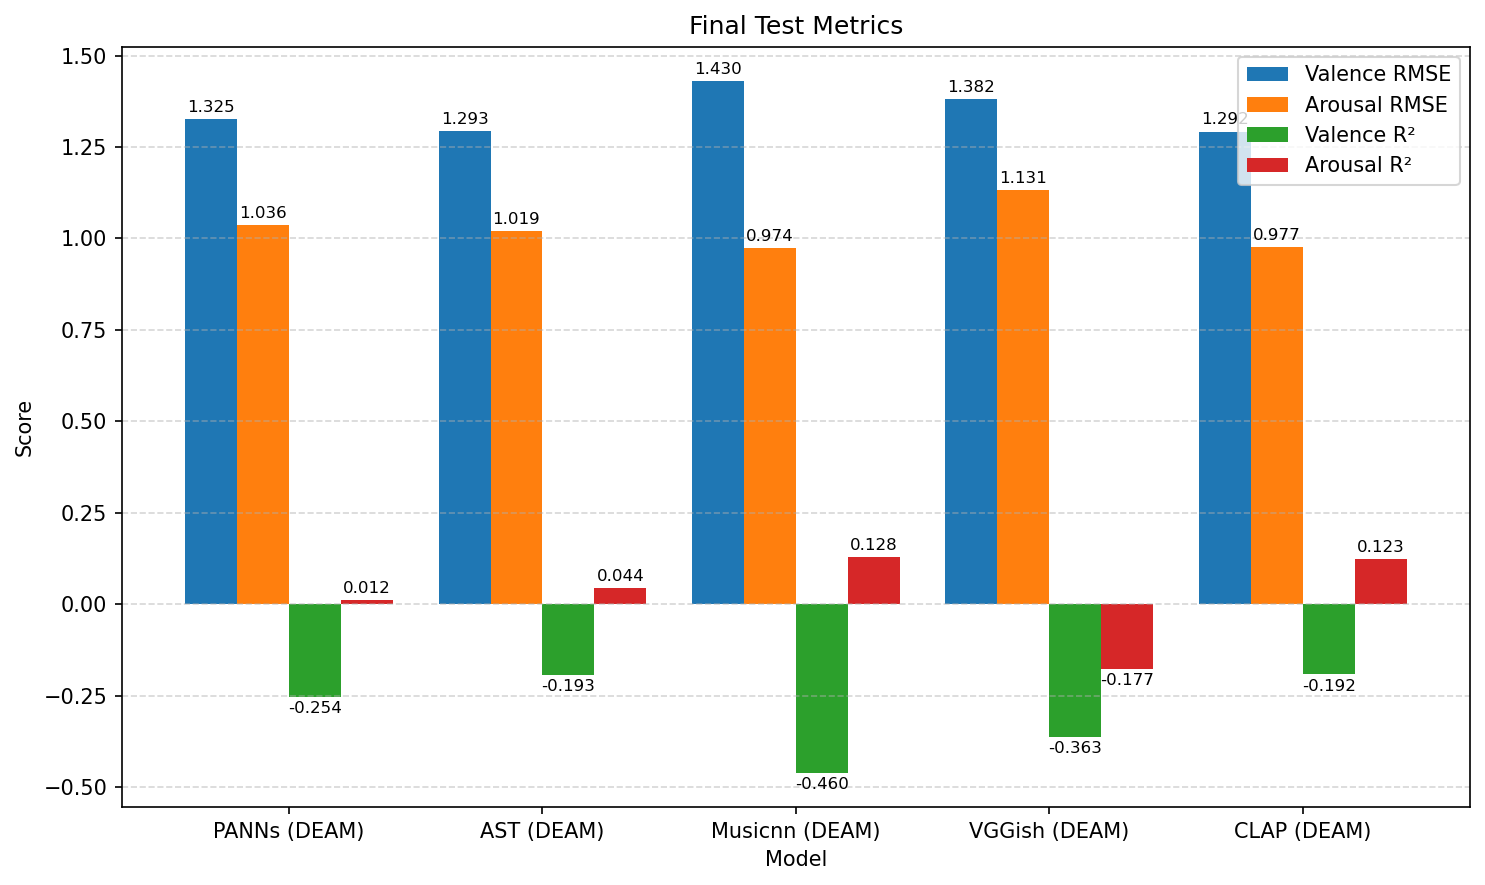

In [51]:
jsons_orig = {
    "PANNs (DEAM)":      "../results/transfer/orig_split/PANNs_effb0/test_metrics.json",
    "AST (DEAM)":        "../results/transfer/orig_split/AST_mobv3/test_metrics.json",
    "Musicnn (DEAM)":    "../results/transfer/orig_split/Musicnn_mobv3/test_metrics.json",
    "VGGish (DEAM)":     "../results/transfer/orig_split/VGGish_effb0/test_metrics.json",
    "CLAP (DEAM)":       "../results/transfer/orig_split/CLAP_effb0/test_metrics.json",
}
results_orig = load_results_from_jsons(jsons_orig)

plot_results_bar(results_orig, savename=Path("../results/plots/transfer_learning/orig_cv/test_metrics_bar_deam_only.png"))

In [12]:
import torch
from huggingface_hub import snapshot_download, hf_hub_download

REPO_ID = "amaai-lab/music2emo"

# 1) Get code
repo_local = snapshot_download(REPO_ID)
sys.path.append(repo_local)

# 2) Import model class used in the repo
from model.linear_mt_attn_ck import FeedforwardModelMTAttnCK  # same file name in repo

device = "cuda" if torch.cuda.is_available() else "cpu"

# 3) Build the model with repo’s expected sizes
model = FeedforwardModelMTAttnCK(
    input_size=768*2,               # MERT layers 5+6 → 1536
    output_size_classification=56,  # mood tags
    output_size_regression=2        # valence, arousal
).to(device)

# 4) Download the correct checkpoint (pick the dataset you care about)
#    For DEAM evaluation, use D_all.ckpt; for Jamendo use J_all.ckpt, etc.
ckpt_path = hf_hub_download(REPO_ID, filename="saved_models/D_all.ckpt")

# 5) Load weights (Lightning-style state_dict with 'model.' prefix)
ckpt = torch.load(ckpt_path, map_location=device)
state = ckpt.get("state_dict", ckpt)
state = {k.replace("model.", ""): v for k,v in state.items()}  # strip wrapper
missing, unexpected = model.load_state_dict(state, strict=False)
print("missing:", missing[:10], "unexpected:", unexpected[:10])

model.eval()
print("Model ready on", device)

Fetching 90 files:   0%|          | 0/90 [00:00<?, ?it/s]

missing: [] unexpected: ['loss_fn_classification.weight', 'loss_fn_classification.pos_weight', 'loss_fn_classification_eval.weight', 'loss_fn_classification_eval.pos_weight']
Model ready on cuda


In [30]:
EMBEDDING_DIR = Path("../data/processed/mert_embeddings/")
# --- 2. Run Inference on All Embeddings ---
all_predictions = {}
embedding_files = list(EMBEDDING_DIR.glob("*.npy"))

with torch.no_grad():
    for embed_path in tqdm(embedding_files, desc="Getting V-A Predictions"):
        song_id = int(embed_path.stem)
        embedding = np.load(embed_path)
        embedding_tensor = torch.FloatTensor(embedding).unsqueeze(0).to(device)  # (1,1536)

        pad = torch.zeros((1, 1), dtype=torch.long, device=device)

        model_input = {
            "x_mert":       embedding_tensor,
            "x_chord_root": pad,
            "x_chord_attr": pad,
            "x_key":        pad
        }
        cls_out, reg_out = model(model_input)   # unpack
        
        # Only care about regression (valence, arousal)
        pred_np = reg_out.squeeze().detach().cpu().numpy()
        
        all_predictions[song_id] = [float(pred_np[0]), float(pred_np[1])]

Getting V-A Predictions: 100%|████████████████████████████████████████████████████| 1802/1802 [00:01<00:00, 1064.79it/s]


In [31]:
# --- 3. Evaluate the Results ---
print("Evaluating results...")
labels_df = labels.copy()
pred_df = pd.DataFrame.from_dict(all_predictions, orient='index', columns=['valence_pred', 'arousal_pred'])

# Combine ground truth and predictions
results_df = labels_df.join(pred_df).dropna()

# Get the columns for evaluation
y_true_valence = results_df['valence_mean']
y_pred_valence = results_df['valence_pred']
y_true_arousal = results_df['arousal_mean']
y_pred_arousal = results_df['arousal_pred']

Evaluating results...


In [32]:
# Calculate final scores
r2_v = r2_score(y_true_valence, y_pred_valence)
r2_a = r2_score(y_true_arousal, y_pred_arousal)
rmse_v = np.sqrt(mean_squared_error(y_true_valence, y_pred_valence))
rmse_a = np.sqrt(mean_squared_error(y_true_arousal, y_pred_arousal))

print("\n" + "="*50)
print("FINAL ZERO-SHOT PERFORMANCE")
print("="*50)
print(f"R² Valence: {r2_v:.4f}")
print(f"R² Arousal: {r2_a:.4f}")
print(f"RMSE Valence: {rmse_v:.4f}")
print(f"RMSE Arousal: {rmse_a:.4f}")


FINAL ZERO-SHOT PERFORMANCE
R² Valence: 0.4088
R² Arousal: 0.6411
RMSE Valence: 0.9026
RMSE Arousal: 0.7679


In [117]:
results_dir = Path('../results/transfer_learning')

In [115]:
all_ids = list(train_ids) + list(val_ids) + list(test_ids)

In [119]:
# Block 6: Zero-shot evaluation
print("\nEvaluating music2emo zero-shot")
embedding_dir = Path('../data/processed/mert_embeddings/')

test_metrics = evaluate_music2emo(embedding_dir, labels, val_ids)

# Save with empty history since there's no training
save_results('music2emo_zeroshot_Custom_Split', {}, test_metrics, results_dir)

print(f"music2emo: Test RMSE V={test_metrics['rmse_v']:.3f}, A={test_metrics['rmse_a']:.3f}")


Evaluating music2emo zero-shot


Fetching 90 files:   0%|          | 0/90 [00:00<?, ?it/s]

Running inference: 100%|█████████████████████████████████████████████████████████████| 294/294 [00:00<00:00, 775.98it/s]

music2emo: Test RMSE V=0.959, A=0.804


In [144]:
import numpy as np, torch, pandas as pd
from torch.utils.data import Dataset, DataLoader

EMB_DIR = Path("../data/processed/mert_embeddings")

def norm(v):  # 1-9 → −1..1
    return (v - 5.0) / 4.0

class MertEmbedDataset(Dataset):
    def __init__(self, ids, labels):
        self.ids = list(ids)
        self.labels = labels
    
    def __len__(self): return len(self.ids)
    
    def __getitem__(self, idx):
        sid = self.ids[idx]
    
        # embedding
        emb = np.load(EMB_DIR / f"{sid}.npy").astype(np.float32)          # (1536,)
    
        # labels → always float32 ndarray
        y  = labels.loc[sid, ['valence_mean', 'arousal_mean']].to_numpy(dtype=np.float32)
    
        return torch.from_numpy(emb), torch.from_numpy(norm(y))

batch_size = 32
train_dl = DataLoader(MertEmbedDataset(train_ids, labels), batch_size, shuffle=True)
val_dl   = DataLoader(MertEmbedDataset(val_ids,   labels), batch_size, shuffle=False)
test_dl  = DataLoader(MertEmbedDataset(test_ids,  labels), batch_size, shuffle=False)

In [152]:
# 1. Define model, optimizer, loss once
model = VARegressor(in_dim=1536, hidden=28).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=5, factor=0.5)

criterion = nn.MSELoss()

# 2. Epoch function
def run_epoch(dl, training=True):
    model.train() if training else model.eval()
    total, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(training):
            pred = model(xb) # forward
            loss = criterion(pred, yb)
            if training:
                opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 0.75)
                opt.step()
        total += loss.item() * len(xb)
        n += len(xb)
    return total/n

In [153]:
len(train_ids)

1278

In [154]:
import time

In [155]:
# 3. Training loop
best_val, patience, patience_lim = 1e9, 0, 10
for epoch in range(100):
    t0 = time.time()
    tr = run_epoch(train_dl, True)
    vl = run_epoch(val_dl, False)
    scheduler.step(vl)

    print(f"epoch {epoch+1:2d}  train {tr:.4f}  val {vl:.4f}  time {time.time()-t0:.1f}s")
    if vl < best_val:
        best_val, patience = vl, 0
        torch.save(model.state_dict(), "best_regressor.pth")
    else:
        patience += 1
        if patience >= patience_lim:
            break

epoch  1  train 0.3224  val 0.0728  time 0.5s
epoch  2  train 0.2566  val 0.0943  time 0.5s
epoch  3  train 0.2217  val 0.0872  time 0.5s
epoch  4  train 0.2012  val 0.0747  time 0.5s
epoch  5  train 0.2015  val 0.0679  time 0.5s
epoch  6  train 0.1696  val 0.0695  time 0.5s
epoch  7  train 0.1721  val 0.0641  time 0.5s
epoch  8  train 0.1498  val 0.0606  time 0.5s
epoch  9  train 0.1417  val 0.0568  time 0.5s
epoch 10  train 0.1253  val 0.0553  time 0.5s
epoch 11  train 0.1245  val 0.0527  time 0.5s
epoch 12  train 0.1147  val 0.0521  time 0.5s
epoch 13  train 0.1080  val 0.0522  time 0.5s
epoch 14  train 0.0992  val 0.0491  time 0.5s
epoch 15  train 0.0958  val 0.0478  time 0.5s
epoch 16  train 0.0893  val 0.0483  time 0.5s
epoch 17  train 0.0814  val 0.0482  time 0.5s
epoch 18  train 0.0843  val 0.0474  time 0.5s
epoch 19  train 0.0770  val 0.0454  time 0.5s
epoch 20  train 0.0727  val 0.0458  time 0.5s
epoch 21  train 0.0699  val 0.0449  time 0.5s
epoch 22  train 0.0677  val 0.0443

In [156]:
model.load_state_dict(torch.load("best_regressor.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb,yb in test_dl:
        y_true.append(yb)
        y_pred.append(model(xb.to(device)).cpu())
y_true = torch.cat(y_true)*4+5    # back to 1-9
y_pred = torch.cat(y_pred)*4+5

from sklearn.metrics import mean_squared_error, r2_score
rmse_v = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
rmse_a = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]))
r2_v   = r2_score(y_true[:,0], y_pred[:,0])
r2_a   = r2_score(y_true[:,1], y_pred[:,1])

print(f"RMSE  V {rmse_v:.3f}  A {rmse_a:.3f}")
print(f"R²    V {r2_v:.3f}  A {r2_a:.3f}")

RMSE  V 0.856  A 0.814
R²    V 0.417  A 0.573


In [157]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# y_true and y_pred are your denormalized tensors, shape (N,2)
y_true = y_true.numpy()
y_pred = y_pred.numpy()

# RMSE
rmse_v = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
rmse_a = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]))

# R²
r2_v = r2_score(y_true[:,0], y_pred[:,0])
r2_a = r2_score(y_true[:,1], y_pred[:,1])

# Pearson correlation
r_v, _ = pearsonr(y_true[:,0], y_pred[:,0])
r_a, _ = pearsonr(y_true[:,1], y_pred[:,1])

print(f"RMSE  V {rmse_v:.3f}  A {rmse_a:.3f}")
print(f"R²    V {r2_v:.3f}  A {r2_a:.3f}")
print(f"r     V {r_v:.3f}  A {r_a:.3f}")

RMSE  V 0.856  A 0.814
R²    V 0.417  A 0.573
r     V 0.651  A 0.757


In [158]:
save_results(
    name="MERT_Embeddings_DeezerPretrain_DEAMFinetune_Custom_Split",
    history=history,
    test_metrics=test_metrics,
    save_dir=Path("../results/transfer_learning/")
)

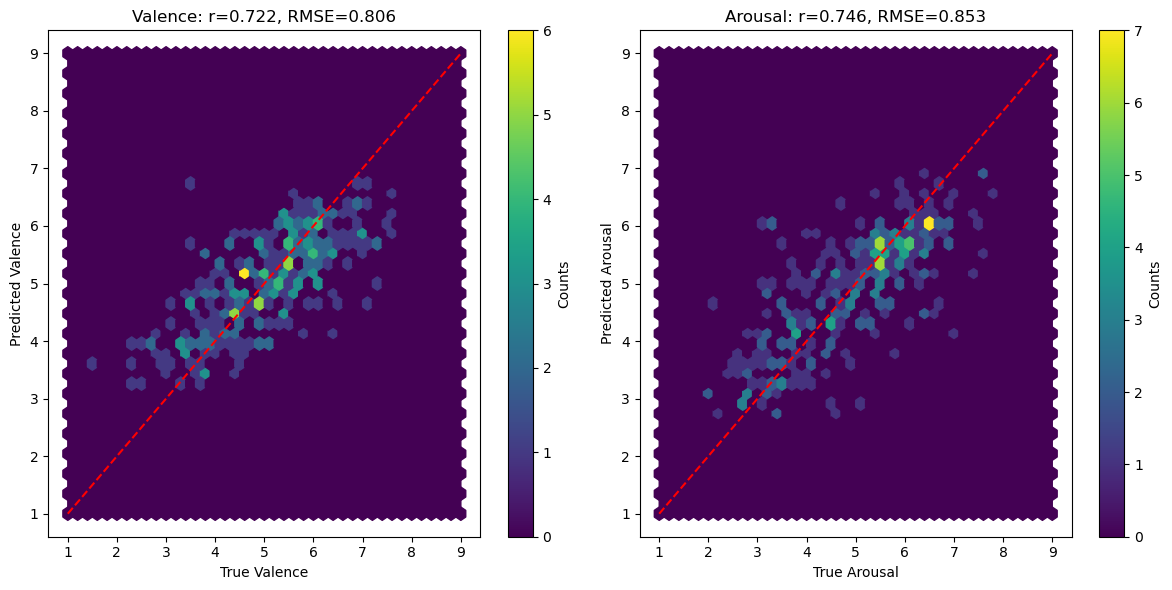

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# true and predicted as numpy arrays (N,2)
true_v, true_a = y_true[:,0], y_true[:,1]
pred_v, pred_a = y_pred[:,0], y_pred[:,1]

# metrics
r_v, _   = pearsonr(true_v, pred_v)
r_a, _   = pearsonr(true_a, pred_a)
rmse_v   = np.sqrt(mean_squared_error(true_v, pred_v))
rmse_a   = np.sqrt(mean_squared_error(true_a, pred_a))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Valence
hb1 = axes[0].hexbin(true_v, pred_v, gridsize=40, cmap="viridis", extent=[1,9,1,9])
axes[0].plot([1,9],[1,9],'r--')
axes[0].set_xlabel("True Valence")
axes[0].set_ylabel("Predicted Valence")
axes[0].set_title(f"Valence: r={r_v:.3f}, RMSE={rmse_v:.3f}")
fig.colorbar(hb1, ax=axes[0], label="Counts")

# Arousal
hb2 = axes[1].hexbin(true_a, pred_a, gridsize=40, cmap="viridis", extent=[1,9,1,9])
axes[1].plot([1,9],[1,9],'r--')
axes[1].set_xlabel("True Arousal")
axes[1].set_ylabel("Predicted Arousal")
axes[1].set_title(f"Arousal: r={r_a:.3f}, RMSE={rmse_a:.3f}")
fig.colorbar(hb2, ax=axes[1], label="Counts")

plt.tight_layout()
plt.show()

In [84]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train = np.stack([np.load(EMB_DIR/f"{sid}.npy") for sid in train_ids])
y_train = labels.loc[train_ids][['valence_mean','arousal_mean']].values

X_test  = np.stack([np.load(EMB_DIR/f"{sid}.npy") for sid in val_ids])
y_test  = labels.loc[val_ids][['valence_mean','arousal_mean']].values

# Normalize to (-1,1)
norm = lambda x: (x - 5) / 4
y_train_n = norm(y_train)
y_val_n  = norm(y_test)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train_n)
pred_n = model.predict(X_test)
pred   = pred_n * 4 + 5

rmse_v = np.sqrt(mean_squared_error(y_test[:,0], pred[:,0]))
rmse_a = np.sqrt(mean_squared_error(y_test[:,1], pred[:,1]))

print(f"Ridge RMSE: V={rmse_v:.3f}  A={rmse_a:.3f}")

Ridge RMSE: V=0.866  A=0.864


In [76]:
for p in model.parameters(): p.requires_grad = False
model.regression_branch = nn.Linear(model.d_model, 2)
for p in model.regression_branch.parameters(): p.requires_grad = True

# unfreeze last 2 blocks
for name,p in model.named_parameters():
    if "blocks.10" in name or "blocks.11" in name:
        p.requires_grad = True

opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=3e-5, weight_decay=1e-4)

AttributeError: 'VARegressor' object has no attribute 'd_model'

In [77]:
print("train",len(train_ids),"val",len(val_ids),"test",len(test_ids))
print(labels.loc[train_ids]['valence_mean'].describe())
print(labels.loc[test_ids]['valence_mean'].describe())


train 1450 val 294 test 58
count    1450.000000
mean        4.872614
std         1.173536
min         1.900000
25%         4.000000
50%         4.900000
75%         5.800000
max         8.400000
Name: valence_mean, dtype: float64
count    58.000000
mean      4.923793
std       1.193966
min       3.000000
25%       3.807500
50%       5.000000
75%       5.950000
max       7.200000
Name: valence_mean, dtype: float64


In [219]:
# Load DEAM labels
labels = pd.read_parquet('../data/processed/core_dataset.parquet')
labels = labels.set_index('song_id')
labels.index = labels.index.astype(int)

# Now create DEAM dataloaders with the new split
from src.train_transfer_learning import DEAMEmotionDataset
from src.train_transfer_learning import DeezerEmotionDataset
from torch.utils.data import DataLoader

spec_dir = Path('../data/processed/mel_spectrograms_panns/')

# Create datasets
deam_train_dataset = DEAMEmotionDataset(
    song_ids=train_ids,
    spectrogram_dir=spec_dir,
    labels_df=labels,
    return_weights=True,
    max_segments_per_song=4
)

deam_val_dataset = DEAMEmotionDataset(
    song_ids=val_ids,
    spectrogram_dir=spec_dir,
    labels_df=labels,
    return_weights=True,
    max_segments_per_song=4
)

deam_test_dataset = DEAMEmotionDataset(
    song_ids=test_ids,
    spectrogram_dir=spec_dir,
    labels_df=labels,
    return_weights=True,
    max_segments_per_song=4
)

# Create loaders
deam_train_loader = DataLoader(deam_train_dataset, batch_size=32, shuffle=True, num_workers=2)
deam_val_loader = DataLoader(deam_val_dataset, batch_size=32, shuffle=False, num_workers=2)
deam_test_loader = DataLoader(deam_test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"DEAM loaders ready: {len(deam_train_loader)} train batches, "
      f"{len(deam_val_loader)} val batches, {len(deam_test_loader)} test batches")

Dataset created with 5800 segments from 1450 songs
Dataset created with 1176 segments from 294 songs
Dataset created with 232 segments from 58 songs
DEAM loaders ready: 182 train batches, 37 val batches, 8 test batches


In [220]:
# Load deezer csvs
deezer_train = pd.read_parquet('../data/Deezer/train.parquet')
deezer_val   = pd.read_parquet('../data/Deezer/val.parquet')
deezer_test  = pd.read_parquet('../data/Deezer/test.parquet')

# build pretrain splits
deezer_pretrain = pd.concat([deezer_train, deezer_test], ignore_index=True)  # train+test = big training set
deezer_val = deezer_val.reset_index(drop=True) # keep val separate

In [221]:
# build datasets
deezer_specs = Path('../data/processed/DEEZER/mel_spectrograms_panns/')

deezer_train_dataset = DeezerEmotionDataset(deezer_pretrain, deezer_specs)
deezer_val_dataset   = DeezerEmotionDataset(deezer_val, deezer_specs)

Deezer dataset created with 28097 segments from 9352 songs
Deezer dataset created with 7457 segments from 2482 songs


In [222]:
# build loaders
deezer_train_loader = DataLoader(deezer_train_dataset, batch_size=64, shuffle=True, num_workers=2)
deezer_val_loader   = DataLoader(deezer_val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [223]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [224]:
def pretrain_then_finetune(model_name='efficientnet_b0'):
    """Complete pipeline: Deezer pretrain → DEAM finetune"""
    history = {
        "pretrain_train_loss": [],
        "pretrain_val_loss": [],
        "finetune_val_loss": []
    }
    # Stage 1: Pretrain on Deezer
    print(f"Stage 1: Pretraining on Deezer ({len(deezer_train)} samples)")
    
    from src.minimal_utils import PretrainedModel
    model = PretrainedModel(backbone_name=model_name, freeze=False, dropout=0.3)
    model = model.to(device)
    
    # Train with reasonable LR
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
    
    best_val_loss = float('inf')
    patience = 0
    for epoch in range(15):
        # Training
        model.train()
        train_losses = []
        for batch in deezer_train_loader:
            specs, labels = batch
            specs, labels = specs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            preds = model(specs)
            loss = F.mse_loss(preds, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in deezer_val_loader:
                specs, labels = batch
                specs, labels = specs.to(device), labels.to(device)
                preds = model(specs)
                val_losses.append(F.mse_loss(preds, labels).item())
        
        avg_train = np.mean(train_losses)
        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}/15: Train={avg_train:.4f}, Val={avg_val:.4f}")

        history["pretrain_train_loss"].append(avg_train)
        history["pretrain_val_loss"].append(avg_val)
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), f'{model_name}_deezer_pretrained.pth')
            patience = 0 # Reset patience on improvement
        else:
            patience += 1
            if patience > 1:
                print(f"Early stopping at pretraining epoch {epoch+1}")
                break
        
        scheduler.step()
    
    # Stage 2: Finetune on DEAM
    print(f"\nStage 2: Finetuning on DEAM (frozen backbone, tiny LR)")
    
    # Create fresh model and load Deezer weights
    model = PretrainedModel(backbone_name=model_name, freeze=True, dropout=0.5)
    model.load_state_dict(torch.load(f'{model_name}_deezer_pretrained.pth'), strict=False)
    model = model.to(device)
    
    # Only optimize the regression head with TINY learning rate
    optimizer = torch.optim.AdamW(model.regressor.parameters(), lr=1e-6, weight_decay=1e-4)
    
    # Very conservative training
    best_deam_val = float('inf')
    patience = 0
    for epoch in range(30):
        # Train on DEAM
        model.train()
        for batch in deam_train_loader:
            if len(batch) == 4:
                specs, labels, weights, song_ids = batch
            else:
                specs, labels, song_ids = batch
                weights = torch.ones(specs.size(0))
            
            specs, labels = specs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            preds = model(specs)
            loss = F.mse_loss(preds, labels)
            loss.backward()
            optimizer.step()
        
        # Validate on DEAM
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in deam_val_loader:
                if len(batch) == 4:
                    specs, labels, weights, song_ids = batch
                else:
                    specs, labels, song_ids = batch
                
                specs, labels = specs.to(device), labels.to(device)
                preds = model(specs)
                val_losses.append(F.mse_loss(preds, labels).item())
        
        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}: Val={avg_val:.4f}")

        history["finetune_val_loss"].append(avg_val)
        
        if avg_val < best_deam_val:
            best_deam_val = avg_val
            torch.save(model.state_dict(), f'{model_name}_deam_finetuned.pth')
            patience = 0
        else:
            patience += 1
            if patience > 5:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Evaluate on test
    model.load_state_dict(torch.load(f'{model_name}_deam_finetuned.pth'))
    model.eval()
    
    from src.train_transfer_learning import EmotionTrainer
    trainer = EmotionTrainer(model=model)
    trainer.model = model
    test_metrics = trainer.validate(deam_test_loader)
    
    return history, test_metrics

In [225]:
history, test_metrics = pretrain_then_finetune()

Stage 1: Pretraining on Deezer (7192 samples)
Epoch 1/15: Train=0.0957, Val=0.0924
Epoch 2/15: Train=0.0877, Val=0.0930
Epoch 3/15: Train=0.0813, Val=0.0934
Early stopping at pretraining epoch 3

Stage 2: Finetuning on DEAM (frozen backbone, tiny LR)
Epoch 1: Val=0.0736
Epoch 2: Val=0.0724
Epoch 3: Val=0.0707
Epoch 4: Val=0.0690
Epoch 5: Val=0.0687
Epoch 6: Val=0.0673
Epoch 7: Val=0.0662
Epoch 8: Val=0.0658
Epoch 9: Val=0.0646
Epoch 10: Val=0.0632
Epoch 11: Val=0.0629
Epoch 12: Val=0.0622
Epoch 13: Val=0.0615
Epoch 14: Val=0.0615
Epoch 15: Val=0.0607
Epoch 16: Val=0.0608
Epoch 17: Val=0.0604
Epoch 18: Val=0.0598
Epoch 19: Val=0.0591
Epoch 20: Val=0.0586
Epoch 21: Val=0.0589
Epoch 22: Val=0.0593
Epoch 23: Val=0.0587
Epoch 24: Val=0.0580
Epoch 25: Val=0.0578
Epoch 26: Val=0.0576
Epoch 27: Val=0.0571
Epoch 28: Val=0.0569
Epoch 29: Val=0.0571
Epoch 30: Val=0.0564


Validating: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.86it/s]


In [226]:
test_metrics

{'loss': 0.09472614949483261,
 'rmse_v': 1.239636422738102,
 'rmse_a': 1.0175008030543802,
 'r2_v': -0.09687769412994385,
 'r2_a': 0.047700345516204834}

In [227]:
save_results(
    name="EffNetB0_DeezerPretrain_DEAMFinetune_PANNs_Orig_Split",
    history=history,
    test_metrics=test_metrics,
    save_dir=Path("../results/transfer_learning/")
)

In [ ]:
# Results comparison table
results_df = pd.DataFrame({
    'Method': ['RF (5-fold CV)', 'RF (old test)', 'Music2Emo (val)', 'Music2Emo (old test)', 
               'VARegressor (val)', 'VARegressor (old test)'],
    'Valence RMSE': [0.829, 1.570, 0.959, 1.276, 0.837, 1.190],
    'Arousal RMSE': [None, 1.233, 0.804, 0.811, 0.900, 0.919],
    'Split Used': ['CV', 'Test(58)', 'Val(294)', 'Test(58)', 'Val(294)', 'Test(58)']
})

# This clearly shows test set is ~50% worse across all methods

In [185]:
# Modified MertEmbedDataset that only uses existing embeddings
class MertEmbedDataset(Dataset):
    def __init__(self, ids, labels_df, emb_dir, dataset_type='deam'):
        self.emb_dir = Path(emb_dir)
        self.labels_df = labels_df
        self.dataset_type = dataset_type
        
        # Filter to only IDs that have embeddings
        self.valid_ids = []
        for sid in ids:
            if (self.emb_dir / f"{sid}.npy").exists():
                self.valid_ids.append(sid)
        
        print(f"Found {len(self.valid_ids)}/{len(ids)} embeddings in {emb_dir}")
        
    def __len__(self): 
        return len(self.valid_ids)
    
    def __getitem__(self, idx):
        sid = self.valid_ids[idx]
        emb = np.load(self.emb_dir / f"{sid}.npy").astype(np.float32)
        
        if self.dataset_type == 'deam':
            # DEAM: 1-9 scale
            v = self.labels_df.loc[sid, 'valence_mean']
            a = self.labels_df.loc[sid, 'arousal_mean']
            v_norm = (v - 5.0) / 4.0
            a_norm = (a - 5.0) / 4.0
            
        else:  # deezer
            # Find row with this dzr_sng_id
            row = self.labels_df[self.labels_df['dzr_sng_id'] == sid].iloc[0]
            v = row['valence']
            a = row['arousal']
            v_norm = v / 3.0
            a_norm = a / 3.0
        
        return torch.from_numpy(emb), torch.FloatTensor([v_norm, a_norm])

# Check what embeddings you actually have
DEEZER_EMB_DIR = Path("../data/processed/DEEZER/mert_embeddings")
if DEEZER_EMB_DIR.exists():
    existing_deezer_embs = [f.stem for f in DEEZER_EMB_DIR.glob("*.npy")]
    print(f"Found {len(existing_deezer_embs)} Deezer MERT embeddings")
else:
    print(f"Warning: {DEEZER_EMB_DIR} does not exist!")
    print("You need to generate MERT embeddings for Deezer first")
    # Fall back to using DEAM only
    DEEZER_EMB_DIR = DEAM_EMB_DIR  # Use DEAM embeddings as fallback

Found 12089 Deezer MERT embeddings


In [186]:
# Load DEAM labels and splits
labels = pd.read_parquet('../data/processed/core_dataset.parquet')
labels = labels.set_index('song_id')
labels.index = labels.index.astype(int)

# Load the split you saved earlier
import json
#with open('../data/processed/deam_split_70_15_15.json', 'r') as f:
   #split_info = json.load(f)
    #train_ids = split_info['train_ids']
    #val_ids = split_info['val_ids']
    #test_ids = split_info['test_ids']

# Now create the dataloaders
DEAM_EMB_DIR = Path("../data/processed/mert_embeddings")
DEEZER_EMB_DIR = Path("../data/processed/DEEZER/mert_embeddings")

# Deezer loaders (use dzr_sng_id directly from dataframes)
deezer_train_loader = DataLoader(
    MertEmbedDataset(deezer_pretrain['dzr_sng_id'].tolist(), deezer_pretrain, DEEZER_EMB_DIR, 'deezer'),
    batch_size=64, shuffle=True
)
deezer_val_loader = DataLoader(
    MertEmbedDataset(deezer_val['dzr_sng_id'].tolist(), deezer_val, DEEZER_EMB_DIR, 'deezer'),
    batch_size=64, shuffle=False
)

# DEAM loaders (using the loaded split)
deam_train_loader = DataLoader(
    MertEmbedDataset(train_ids, labels, DEAM_EMB_DIR, 'deam'),
    batch_size=32, shuffle=True
)
deam_val_loader = DataLoader(
    MertEmbedDataset(val_ids, labels, DEAM_EMB_DIR, 'deam'),
    batch_size=32, shuffle=False
)
deam_test_loader = DataLoader(
    MertEmbedDataset(test_ids, labels, DEAM_EMB_DIR, 'deam'),
    batch_size=32, shuffle=False
)

Found 9352/9352 embeddings in ../data/processed/DEEZER/mert_embeddings
Found 2482/2482 embeddings in ../data/processed/DEEZER/mert_embeddings
Found 1450/1450 embeddings in ../data/processed/mert_embeddings
Found 294/294 embeddings in ../data/processed/mert_embeddings
Found 58/58 embeddings in ../data/processed/mert_embeddings


In [187]:
# Dataset for MERT embeddings (works for both DEAM and Deezer)
class MertEmbedDataset(Dataset):
    def __init__(self, ids, labels_df, emb_dir, dataset_type='deam'):
        self.ids = list(ids)
        self.labels_df = labels_df
        self.emb_dir = Path(emb_dir)
        self.dataset_type = dataset_type
        
    def __len__(self): 
        return len(self.ids)
    
    def __getitem__(self, idx):
        if self.dataset_type == 'deam':
            sid = self.ids[idx]
            emb = np.load(self.emb_dir / f"{sid}.npy").astype(np.float32)
            
            # DEAM: 1-9 scale
            v = self.labels_df.loc[sid, 'valence_mean']
            a = self.labels_df.loc[sid, 'arousal_mean']
            v_norm = (v - 5.0) / 4.0  # to [-1, 1]
            a_norm = (a - 5.0) / 4.0
            
        else:  # deezer
            # Assuming ids are dzr_sng_id for Deezer
            sid = self.ids[idx]
            emb = np.load(self.emb_dir / f"{sid}.npy").astype(np.float32)
            
            # Deezer: -3 to 3 scale
            v = self.labels_df.loc[self.labels_df['dzr_sng_id'] == sid, 'valence'].values[0]
            a = self.labels_df.loc[self.labels_df['dzr_sng_id'] == sid, 'arousal'].values[0]
            v_norm = v / 3.0  # to [-1, 1]
            a_norm = a / 3.0
        
        return torch.from_numpy(emb), torch.FloatTensor([v_norm, a_norm])

# VARegressor
class VARegressor(nn.Module):
    def __init__(self, in_dim=1536, hidden=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, 2)
        )
    
    def forward(self, x):
        return self.mlp(x)

In [188]:
len(test_ids)

58

In [189]:
from src.minimal_utils import *
# Run pipeline
history, test_metrics = pretrain_mert_then_finetune(
    model_class=VARegressor,
    deezer_train_loader=deezer_train_loader,
    deezer_val_loader=deezer_val_loader,
    deam_train_loader=deam_train_loader,
    deam_val_loader=deam_val_loader,
    deam_test_loader=deam_test_loader
)

--- Stage 1: Pre-training on Deezer embeddings ---
Epoch  1: Train Loss=0.2910, Val Loss=0.1127
  -> New best pre-train model saved.
Epoch  2: Train Loss=0.2212, Val Loss=0.0997
  -> New best pre-train model saved.
Epoch  3: Train Loss=0.1788, Val Loss=0.0923
  -> New best pre-train model saved.
Epoch  4: Train Loss=0.1558, Val Loss=0.0905
  -> New best pre-train model saved.
Epoch  5: Train Loss=0.1425, Val Loss=0.0892
  -> New best pre-train model saved.
Epoch  6: Train Loss=0.1301, Val Loss=0.0860
  -> New best pre-train model saved.
Epoch  7: Train Loss=0.1207, Val Loss=0.0858
  -> New best pre-train model saved.
Epoch  8: Train Loss=0.1122, Val Loss=0.0856
  -> New best pre-train model saved.
Epoch  9: Train Loss=0.1058, Val Loss=0.0851
  -> New best pre-train model saved.
Epoch 10: Train Loss=0.1008, Val Loss=0.0844
  -> New best pre-train model saved.
Epoch 11: Train Loss=0.0987, Val Loss=0.0846
Epoch 12: Train Loss=0.0965, Val Loss=0.0846
Epoch 13: Train Loss=0.0960, Val Loss=0

In [190]:
test_metrics

{'rmse_v': 1.1274405603748452,
 'rmse_a': 0.901723574260418,
 'r2_v': 0.09268754720687866,
 'r2_a': 0.25208723545074463,
 'test_loss': 1.0421139001846313}

In [191]:
save_results(
    name="MERT_Embeddings_DeezerPretrain_DEAMFinetune_Orig_Split",
    history=history,
    test_metrics=test_metrics,
    save_dir=Path("../results/transfer_learning/")
)

In [204]:
# Run the analysis
orig_results, custom_results = load_and_pair_results("../results/transfer_learning/")
orig_results1, custom_results1 = load_and_pair_results("../results/ML/")
orig_results.update(orig_results1)
custom_results.update(custom_results1)

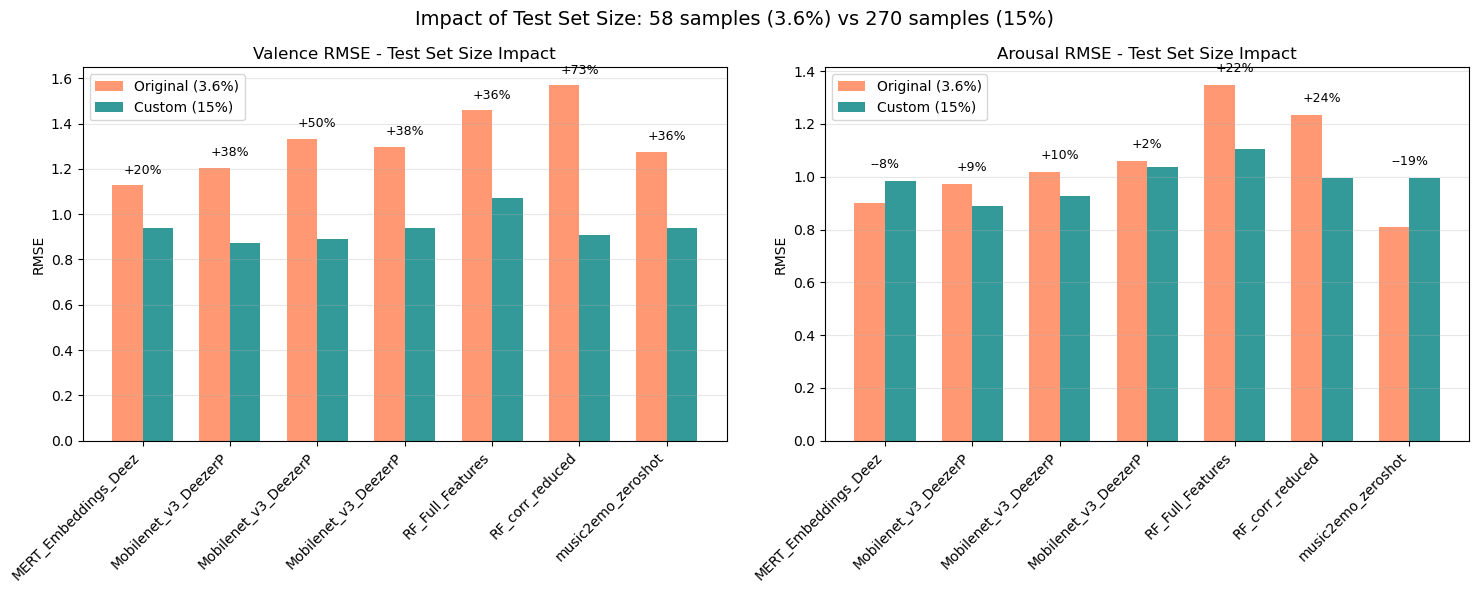


Average performance degradation with 58-sample test set:
  Valence: 41.6% worse
  Arousal: 5.7% worse

Model                          V_orig   V_custom V_diff%  A_orig   A_custom A_diff% 
------------------------------------------------------------------------------------------
MERT_Embeddings_DeezerPretrain 1.127    0.941    19.9     0.902    0.984    -8.4    
Mobilenet_v3_DeezerPretrain_DE 1.205    0.871    38.5     0.972    0.890    9.2     
Mobilenet_v3_DeezerPretrain_DE 1.333    0.891    49.6     1.018    0.925    10.0    
Mobilenet_v3_DeezerPretrain_DE 1.298    0.939    38.3     1.059    1.037    2.1     
RF_Full_Features               1.458    1.072    36.0     1.347    1.105    21.9    
RF_corr_reduced                1.569    0.907    72.9     1.232    0.995    23.9    
music2emo_zeroshot             1.276    0.940    35.8     0.811    0.996    -18.6   


In [205]:
# Run the analysis
#orig_results, custom_results = load_and_pair_results("../results/transfer_learning/")

visualize_split_comparison(orig_results, custom_results)

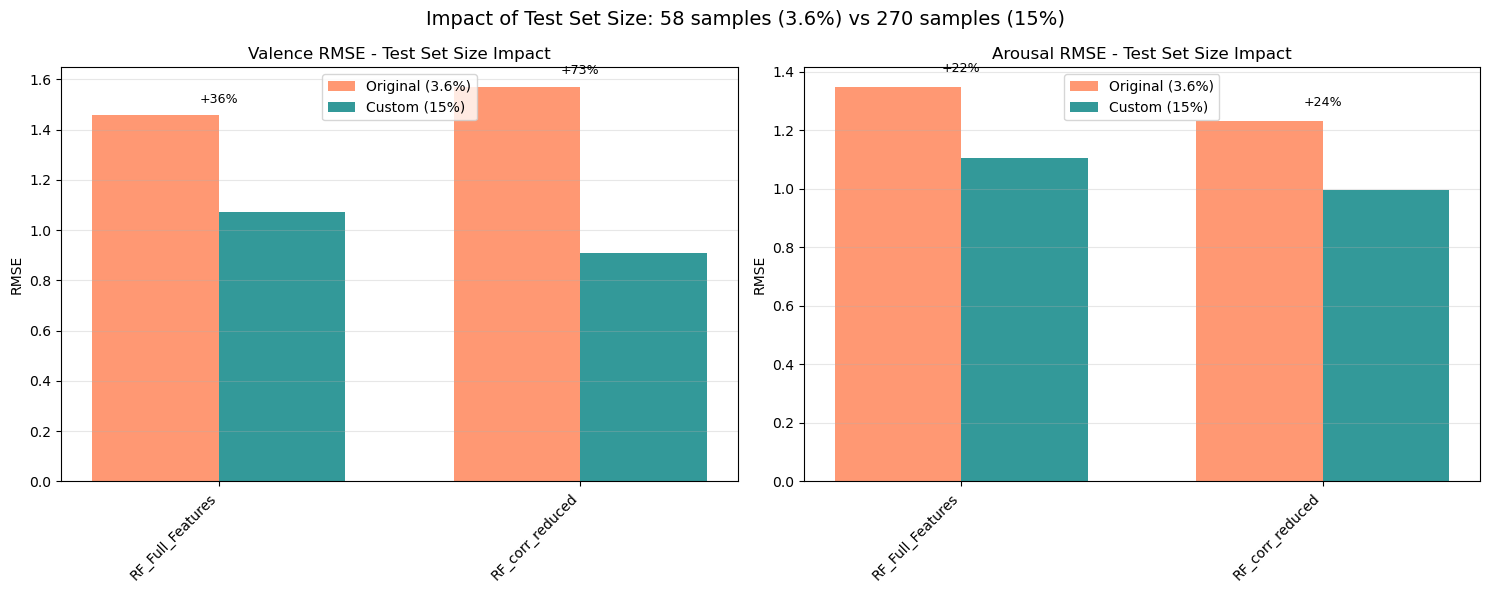


Average performance degradation with 58-sample test set:
  Valence: 54.5% worse
  Arousal: 22.9% worse

Model                          V_orig   V_custom V_diff%  A_orig   A_custom A_diff% 
------------------------------------------------------------------------------------------
RF_Full_Features               1.458    1.072    36.0     1.347    1.105    21.9    
RF_corr_reduced                1.569    0.907    72.9     1.232    0.995    23.9    


In [123]:
# Run the analysis
orig_results, custom_results = load_and_pair_results("../results/ML/")
visualize_split_comparison(orig_results, custom_results)